Notebook author: Makar Shevchenko B20-DS-01

# Model Training and Visualization. Movie Recommender System. Assignment 2. Practical Machine Learning and Deep Learning

## Solution

Apply matrix factorization algrotihm implementation from LightFM [1]

### Imports

In [1]:
import sys

!{sys.executable} -m pip install lightfm

import pickle
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from matplotlib import pyplot as plt
from lightfm.evaluation import auc_score
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import reciprocal_rank
from lightfm.cross_validation import random_train_test_split

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip


/Users/19134925/.local/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Config

In [2]:
POSITIVE_RATING_THRESHOLD = 5
LOSS = "warp"  # as only positive interactions are present
NO_COMPONENTS = 40
EPOCHS = 10
RANDOM_STATE = 42
TEST_PERCENTAGE = 0.2
USER_ID = "user_id"
MOV_ID = "movie_id"
RATING = "rating"
MOV_ID = "movie_id"
MOV_TITLE = "movie_title"
REL_DATE = "release_date"
VID_REL_DATE = "video_release_date"
IMDB_URL = "IMDb_URL"
GEN_UNK = "unknown"
GEN_ACT = "Action"
GEN_ADV = "Adventure"
GEN_ANIM = "Animation"
GEN_CHLD = "Children's"
GEN_CMDY = "Comedy"
GEN_CRM = "Crime"
GEN_DOC = "Documentary"
GEN_DRM = "Drama"
GEN_FNTS = "Fantasy"
GEN_NOIR = "Film-Noir"
GEN_HRR = "Horror"
GEN_MUS = "Musical"
GEN_MSTR = "Mystery"
GEN_RMNS = "Romance"
GEN_SCIFI = "Sci-Fi"
GEN_TRIL = "Thriller"
GEN_WAR = "War"
GEN_WST = "Western"
U_ITEM_COL_NMS = [MOV_ID, MOV_TITLE, REL_DATE, VID_REL_DATE, IMDB_URL, GEN_UNK,
                  GEN_ACT, GEN_ADV, GEN_ANIM, GEN_CHLD, GEN_CMDY, GEN_CRM,
                  GEN_DOC, GEN_DRM, GEN_FNTS, GEN_NOIR, GEN_HRR, GEN_MUS,
                  GEN_MSTR, GEN_RMNS, GEN_SCIFI, GEN_TRIL, GEN_WAR, GEN_WST]
FILES_ENC = "latin-1"
UNZIPPED_DIR_PATH = "../data/raw/ml-100k"
U_ITEM_PATH = UNZIPPED_DIR_PATH + "/u.item"
U_GENRE_PATH = UNZIPPED_DIR_PATH + "/u.genre"
MODEL_PATH = "../models/model_ckpt.pkl"
BENCHMARK_DATA_PATH = "../benchmark/data/eval_data.pkl"
PREPR_DATA_PATH = "../data/interim"
PREPR_U_DATA_PATH = PREPR_DATA_PATH + "/u_data.csv"
PREPR_U_ITEM_PATH = PREPR_DATA_PATH + "/u_item.csv"
PREPR_U_USER_PATH = PREPR_DATA_PATH + "/u_user.csv"
VIS_PATH = "../reports/figures"
EVAL_VIS_PATH = VIS_PATH + "/eval_vis.png"

### Training

#### Load Data

In [3]:
u_data = pd.read_csv(PREPR_U_DATA_PATH, index_col=0)
u_item = pd.read_csv(PREPR_U_ITEM_PATH, index_col=0)
u_user = pd.read_csv(PREPR_U_USER_PATH, index_col=0)
gen2idx = dict()
u_genre = pd.read_csv(U_GENRE_PATH, sep="|", encoding=FILES_ENC, header=None)
for i, col in u_genre.iterrows():
    gen2idx[col[0]] = col[1]

#### Training

Train LightFM to obtain user and items embeddings and embeddings of their features. With that I will be able to estimate the rating that user will give to a movie. The more estimated rating, the better movie as recommendation. Assume that interaction, i.e. connection between user and movie, is present, when user gave 5 rating score to the movie.

In [4]:
dataset = Dataset(user_identity_features=True, item_identity_features=True)
dataset.fit(u_user[USER_ID], u_item[MOV_ID], user_features=u_user.columns[1:],
            item_features=gen2idx.keys())
item_features = zip(u_item[MOV_ID],
                    u_item[gen2idx.keys()].to_dict(orient="records"))
item_features = dataset.build_item_features(item_features)
user_features = zip(u_user[USER_ID],
                    u_user[u_user.columns[1:]].to_dict(orient="records"))
user_features = dataset.build_user_features(user_features)
positive_interactions = u_data.loc[u_data[RATING] >= POSITIVE_RATING_THRESHOLD]
interactions, weights = dataset.build_interactions(
    positive_interactions.itertuples(index=False, name=None)
)
train_interactions, test_interactions = random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE, random_state=RANDOM_STATE
)
train_weights, test_weights = random_train_test_split(
    weights, test_percentage=TEST_PERCENTAGE, random_state=RANDOM_STATE
)
model = LightFM(loss=LOSS, no_components=NO_COMPONENTS,
                random_state=RANDOM_STATE)
model.fit(train_interactions, epochs=EPOCHS, user_features=user_features,
          item_features=item_features, sample_weight=train_weights)

#### Save Trained Model & Benchmark Data

Save the model, training and benchmark data. I use pickle as the library do not provide the alternative for saving

In [5]:
with open(MODEL_PATH, "wb") as file:
    model_ckpt = {
        "dataset": dataset,
        "train_interactions": train_interactions,
        "user_features": user_features,
        "item_features": item_features,
        "model": model
    }
    pickle.dump(model_ckpt, file)
with open(BENCHMARK_DATA_PATH, "wb") as file:
    # data redundancy, however without dataset neither
    # model, nor benchmark data can solely exist
    bench_data = {
        "dataset": dataset,
        "test_interactions": test_interactions,
        "user_features": user_features,
        "item_features": item_features
    }
    pickle.dump(bench_data, file)

### Evaluation

#### Metrics & Benchmark

Assess the model with the following scores [1]:
- ROC AUC metric for a model: the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example;
- Reciprocal rank metric: 1 / the rank of the highest ranked positive example;
- Precision at k metric for a model: the fraction of known positives in the first k positions of the ranked list of results;
- Recall at k metric for a model: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period

Train AUC score:	0.9108256
Test AUC score:	0.8963713
Train Reciprocal rank:	0.44093907
Test Reciprocal rank:	0.16008842


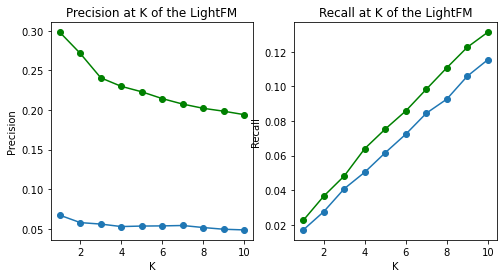

In [6]:
print("Train AUC score:",
      auc_score(model, train_interactions, user_features=user_features,
           item_features=item_features).mean(),
      sep="\t"
)
print("Test AUC score:",
      auc_score(model, test_interactions, user_features=user_features,
           item_features=item_features).mean(),
      sep="\t"
)
print("Train Reciprocal rank:",
      reciprocal_rank(model, train_interactions, user_features=user_features,
                      item_features=item_features).mean(),
      sep="\t")
print("Test Reciprocal rank:",
      reciprocal_rank(model, test_interactions, user_features=user_features,
                      item_features=item_features).mean(),
      sep="\t")
ks = list(range(1, 11))
test_prec_y = []
train_prec_y = []
test_rec_y = []
train_rec_y = []
for k in ks:
    train_prec_y.append(
        precision_at_k(model, train_interactions, k=k,
                       user_features=user_features,
                       item_features=item_features).mean()
    )
    test_prec_y.append(
        precision_at_k(model, test_interactions, k=k,
                       user_features=user_features,
                       item_features=item_features).mean()
    )
    train_rec_y.append(
        recall_at_k(model, train_interactions, k=k,
                    user_features=user_features,
                    item_features=item_features).mean()
    )
    test_rec_y.append(
        recall_at_k(model, test_interactions, k=k,
                    user_features=user_features,
                    item_features=item_features).mean()
    )
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ks, train_prec_y, marker="o", color="g", label="Train")
axes[0].plot(ks, test_prec_y, marker="o", label="Test")
axes[0].title.set_text("Precision at K of the LightFM")
axes[0].set_ylabel("Precision")
axes[0].set_xlabel("K")
axes[1].plot(ks, train_rec_y, marker="o", color="g", label="Train")
axes[1].plot(ks, test_rec_y, marker="o", label="Test")
axes[1].title.set_text("Recall at K of the LightFM")
axes[1].set_ylabel("Recall")
axes[1].set_xlabel("K")
fig.savefig(EVAL_VIS_PATH)

On the test set the model shown the following metrices:
- ROC AUC score = 0.89 is close to 1. This means that the model is good in distinguishing positive and negative classes;
- Reciprocal rank is 0.16. This means that the model usually guess the recommendation right only on the 6th position;
- Precision is about 0.06 that is ok with only 0.01 of true samples for a user. This means that model give right answer only in 1 out of 20 recommendations;
- Recal raises linearly from 0.02 to 0.1 with K raising from 1 to 10

#### Sample Predictions

Here I use the trained model to recommend ten movies for each of three users. I convert user_id to internal model index and pass it to the model. The model ouputs estimated scores to moves. Then I sort the scores in descending order to select top-ten with highest scores - they match most estimated tastes of the user

In [7]:
user_ids = [4, 26, 30]
temp_u_item = pd.read_csv(U_ITEM_PATH, sep="|", encoding=FILES_ENC, header=None,
                          names=U_ITEM_COL_NMS)
user_id2idx, _, item_id2idx, _ = dataset.mapping()
idx2user_id = {v: k for k, v in user_id2idx.items()}
idx2item_id = {v: k for k, v in item_id2idx.items()}
for user_id in user_ids:
    user_idx = user_id2idx[user_id]
    known_positives_idxs = train_interactions.tocsr()[user_idx].indices
    known_positives_ids = [idx2item_id[i] for i in known_positives_idxs]
    print("User %s" % user_id)
    print("\tKnown positives:")
    for i in known_positives_ids[:10]:
        print(f"\t\t{temp_u_item[MOV_TITLE].loc[i-1]}")
    scores = model.predict(user_idx, np.arange(len(temp_u_item)),
                           user_features=user_features,
                           item_features=item_features)
    recommended_idxs = np.argsort(-scores)
    recommended_ids = [idx2item_id[i] for i in recommended_idxs]
    print("\tRecommended:")
    for i in recommended_ids[:10]:
        print(f"\t\t{temp_u_item[MOV_TITLE].loc[i-1]}")

User 4
	Known positives:
		Star Wars (1977)
		Contact (1997)
		Liar Liar (1997)
		Air Force One (1997)
		In & Out (1997)
		Ulee's Gold (1997)
		Lost Highway (1997)
		Cop Land (1997)
		Desperate Measures (1998)
		Wedding Singer, The (1998)
	Recommended:
		Star Wars (1977)
		Raiders of the Lost Ark (1981)
		Usual Suspects, The (1995)
		Godfather, The (1972)
		Return of the Jedi (1983)
		Terminator 2: Judgment Day (1991)
		Fargo (1996)
		Pulp Fiction (1994)
		Empire Strikes Back, The (1980)
		Contact (1997)
User 26
	Known positives:
		Fargo (1996)
		Godfather, The (1972)
		L.A. Confidential (1997)
	Recommended:
		Star Wars (1977)
		Fargo (1996)
		Godfather, The (1972)
		Schindler's List (1993)
		Raiders of the Lost Ark (1981)
		Pulp Fiction (1994)
		Usual Suspects, The (1995)
		Silence of the Lambs, The (1991)
		Contact (1997)
		Shawshank Redemption, The (1994)
User 30
	Known positives:
		Forrest Gump (1994)
		Raiders of the Lost Ark (1981)
		Kolya (1996)
		Contact (1997)
		English Patien

Some of the recommended movies match known positives: Star Wars and Contact for User 4, Fargo and Godfather, The for User 26, and Raiders of the Lost Ark and Contact for Use 30. This means that model trained embeddings correctly: the estimated scores match interactions from train data.

### References

[1] https://making.lyst.com/lightfm/docs/home.html